# Modelling a non-stationary poisson process

>A non-stationary Poisson process (NSPP) is an arrival process with an arrival rate that varies by time.

One of the limitations of queuing theory is the difficulty of modelling time-dependent arrivals.  Computer 
simulation offer a number of ways of modelling non-stationary arrivals.  

In this lab you will learn:
    
* How to implement the thinning algorithm to model a non-stationary poisson process (NSPP)

> **Special thanks** to two 2020/21 students Tamir and Simon who spotted bugs in the original code!

---

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import simpy

# please use simpy version 4
simpy.__version__

'4.0.1'

----
## An example NSPP

The table below breaks an arrival process down into 60 minutes intervals.


| t(min) | Mean time between arrivals (min) | Arrival Rate $\lambda(t)$ (arrivals/min) |
|:------:|:--------------------------------:|:--------------------------------------:|
|    0   |                15                |                  1/15                  |
|   60   |                12                |                  1/12                  |
|   120  |                 7                |                   1/7                  |
|   180  |                 5                |                   1/5                  |
|   240  |                 8                |                   1/8                  |
|   300  |                10                |                  1/10                  |
|   360  |                15                |                  1/15                  |
|   420  |                20                |                  1/20                  |
|   480  |                20                |                  1/20                  |

> **Interpretation**: In the table above the fastest arrival rate is 1/5 customers per minute or 5 minutes between customer arrivals.

## Thinning

Thinning is a acceptance-rejection sampling method and is used to generate inter-arrival times from a NSPP.  

> A NSPP has arrival rate $\lambda(t)$ where $0 \leq t \leq T$

**The thinning algorithm**

A NSPP has arrival rate $\lambda(t)$ where $0 \leq t \leq T$

Here $i$ is the arrival number and $\mathcal{T_i}$ is its arrival time.

1. Let $\lambda^* = \max_{0 \leq t \leq T}\lambda(t)$ be the maximum of the arrival rate function and set $t = 0$ and $i=1$

2. Generate $e$ from the exponential distribution with rate $\lambda^*$ and let $t = t + e$ (this is the time of the next entity will arrive)

3. Generate $u$ from the $U(0,1)$ distribution.  If $u \leq \dfrac{\lambda(t)}{\lambda^*}$ then $\mathcal{T_i} =t$ and $i = i + 1$

4. Go to Step 2.

# Exercise 1: simulation **without thinning**

**Task:**
* Build a simple simpy model that simulates time-dependent arrivals
* For this exercise please **IGNORE** the need for a thinning process.

**Optional task:**
* It is useful to set the sampling of arrivals using a random seed.  This will allow you to compare the number of arrivals before and after adding thinning.  **Remember that an issue with DES without thinning occurs when moving from a period $t$ with a low arrival rate to $t+1$ that has a high one.**

**Hints:**
* Build your model up gradually. 
* Start by building a model that simulates exponential arrivals using a single mean inter-arrival time then add in logic to change which mean you use depending on the simulation time.
* The logic to decide the time period is equivalent to asking yourself "given `env.now()` and that arrival rates are split into 60 minute chunks which row of my dataframe should I select".
* To simplify the task you set the run length of the simulation to no more than 540 minutes.  For an extra challenge think about how you would run the model for longer than 480 minutes and loop back round to the first period (the code to do this is surprising simple).

The data are stored in a file `data/nspp_example1.csv`. 

In [2]:
# your code here ...

In [3]:
# example answer

#read in the data and calculate lambda
arrivals = pd.read_csv('data/nspp_example1.csv')
arrivals['arrival_rate'] = 1 / arrivals['mean_iat']
arrivals

,t,mean_iat,arrival_rate
0,0,15,0.066667
1,60,12,0.083333
2,120,7,0.142857
3,180,5,0.200000
4,240,8,0.125000
5,300,10,0.100000
6,360,15,0.066667
7,420,20,0.050000
8,480,20,0.050000


In [4]:
#This example answer show how to build up your functionality gradually.

# iteration 1: ignoring time dependence.  
# I just use the first mean in the dataframe and build up the basic structure of the code
# A few lines of code and have an incorrect(!) but running model.

def arrivals_generator(env, means, random_seed=None):
    rng = np.random.default_rng(random_seed)
    
    for n in itertools.count():
        interarrival_time = rng.exponential(means['mean_iat'].iloc[0])
        yield env.timeout(interarrival_time)
        print(f'arrival {n} at {env.now}')


In [5]:
RUN_LENGTH = 540
env = simpy.Environment()
env.process(arrivals_generator(env, arrivals, random_seed=42))
env.run(RUN_LENGTH)

arrival 0 at 36.06312905948992
arrival 1 at 71.10597389685671
arrival 2 at 106.87738889497054
arrival 3 at 111.07430324274428
arrival 4 at 112.37086423821994
arrival 5 at 134.1607719738122
arrival 6 at 155.31018238767578
arrival 7 at 202.17462173591824
arrival 8 at 203.36403469367087
arrival 9 at 219.06244739181835
arrival 10 at 220.11899199378547
arrival 11 at 236.45434641414488
arrival 12 at 262.424256707402
arrival 13 at 268.22767907625064
arrival 14 at 286.7014640161742
arrival 15 at 289.0080628235676
arrival 16 at 290.3817218344205
arrival 17 at 295.1094098664064
arrival 18 at 308.6273989969588
arrival 19 at 314.82217894303614
arrival 20 at 333.5329681902405
arrival 21 at 336.8866137734253
arrival 22 at 364.45616773559226
arrival 23 at 382.86245568380616
arrival 24 at 392.6993979932512
arrival 25 at 398.95569858792845
arrival 26 at 405.7554939274024
arrival 27 at 406.9116511332372
arrival 28 at 409.6061349488555
arrival 29 at 419.88594172291926
arrival 30 at 425.7161452653166
arri

In [6]:
#iteration 2.  I've now added an index t used to select the correct mean IAT.

def arrivals_generator(env, means, random_seed=None):
    rng = np.random.default_rng(random_seed)
    
    for n in itertools.count():
        
        # this give us the index of dataframe to use
        # I've used mod 9 so that run_lengh can be > 540
        t = int(env.now // 60) % 9
        interarrival_time = rng.exponential(means['mean_iat'].iloc[t])
        yield env.timeout(interarrival_time)
        print(f'arrival {n} at {env.now}')

In [7]:
RUN_LENGTH = 540
env = simpy.Environment()
env.process(arrivals_generator(env, arrivals, random_seed=42))
env.run(RUN_LENGTH)

arrival 0 at 36.06312905948992
arrival 1 at 71.10597389685671
arrival 2 at 99.72310589534777
arrival 3 at 103.08063737356677
arrival 4 at 104.1178861699473
arrival 5 at 121.54981235842111
arrival 6 at 131.41953721822412
arrival 7 at 153.2896089140706
arrival 8 at 153.8446682943552
arrival 9 at 161.17059422015734
arrival 10 at 161.66364836774198
arrival 11 at 169.2868137639097
arrival 12 at 181.40610523409634
arrival 13 at 183.3405793570459
arrival 14 at 189.49850767035377
arrival 15 at 190.2673739394849
arrival 16 at 190.72526027643588
arrival 17 at 192.30115628709785
arrival 18 at 196.80715266394864
arrival 19 at 198.8720793126411
arrival 20 at 205.1090090617092
arrival 21 at 206.2268909227708
arrival 22 at 215.4167422434931
arrival 23 at 221.55217155956439
arrival 24 at 224.8311523293794
arrival 25 at 226.91658586093848
arrival 26 at 229.1831843074298
arrival 27 at 229.56857004270807
arrival 28 at 230.46673131458084
arrival 29 at 233.8933335726021
arrival 30 at 235.8367347534012
arri

## Exercise 2: Thinning the arrivals

**Task:**
* Update your exercise 1 code to include an implementation of thinning
* What do you notice about the total number of arrivals compared to the previous example? Why has the changed occurred?
   * If you are not controlling your sampling with random seeds you will need to run each implementation a few times.

**Hints:**
* You will need a second distribution - Uniform(0, 1) to do the thinning.  If you are controlling random sampling through seeds that means you will need a second seed.


In [8]:
# your code here ...

In [9]:
#Example answer ...

#I've added an extra bit of code here to report the number of rejections for each arrival
#You wouldn't include that in production code

def arrivals_generator_with_thinning(env, means, audit=None, seed1=None, 
                                     seed2=None):
    
    arr_rng = np.random.default_rng(seed1)
    thinning_rng = np.random.default_rng(seed2)
    
    #maximum arrival rate (smallest time between arrivals)
    lambda_max = means['arrival_rate'].max()
    
    for n in itertools.count():

        # this give us the index of dataframe to use
        t = int(env.now // 60) % 9
        lambda_t = means['arrival_rate'].iloc[t]
        
        #set to a large number so that at least 1 sample taken!
        u = np.Inf
        rejects = -1
        
        interarrival_time = 0.0
        
        # reject samples if u >= lambda_t / lambda_max
        while u >= (lambda_t / lambda_max):
            rejects += 1
            interarrival_time += arr_rng.exponential(1/lambda_max)
            u = thinning_rng.uniform(0, 1)
        
        yield env.timeout(interarrival_time)
        
        #if audit included then record arrival numbers
        if audit != None: 
            audit[-1] += 1
        else:
            print(f'arrival {n} at {env.now:.2f}. Rejected samples = {rejects}')

In [10]:
RUN_LENGTH = 540

env = simpy.Environment()
env.process(arrivals_generator_with_thinning(env, arrivals, 
                                             seed1=42, seed2=101))
env.run(RUN_LENGTH)

arrival 0 at 37.46. Rejected samples = 4
arrival 1 at 73.02. Rejected samples = 4
arrival 2 at 89.41. Rejected samples = 3
arrival 3 at 96.79. Rejected samples = 2
arrival 4 at 98.37. Rejected samples = 0
arrival 5 at 104.94. Rejected samples = 1
arrival 6 at 112.30. Rejected samples = 1
arrival 7 at 121.49. Rejected samples = 0
arrival 8 at 127.62. Rejected samples = 0
arrival 9 at 135.25. Rejected samples = 2
arrival 10 at 135.64. Rejected samples = 0
arrival 11 at 141.91. Rejected samples = 2
arrival 12 at 148.23. Rejected samples = 0
arrival 13 at 155.26. Rejected samples = 2
arrival 14 at 158.47. Rejected samples = 0
arrival 15 at 160.19. Rejected samples = 0
arrival 16 at 167.68. Rejected samples = 2
arrival 17 at 174.35. Rejected samples = 0
arrival 18 at 181.30. Rejected samples = 0
arrival 19 at 186.72. Rejected samples = 0
arrival 20 at 187.09. Rejected samples = 0
arrival 21 at 192.76. Rejected samples = 0
arrival 22 at 199.53. Rejected samples = 0
arrival 23 at 205.14. Reje

# Optional extra: Validate the total number of arrivals in 540 minutes.

Here we will repeat the same 10,000 times and then explore the distribution of the number of arrivals.  If all has gone to plan this should be a Poisson distribution with mean ~53.

In [11]:
RUN_LENGTH = 540
REPLICATIONS = 10_000
audit = []

rng = np.random.default_rng(42)

for i in range(REPLICATIONS):
    #set up audit for replication.
    audit.append(0)
    env = simpy.Environment()
    #don't set the random number generator as we want different results each time.
    env.process(arrivals_generator_with_thinning(env, arrivals, audit))
    env.run(RUN_LENGTH)

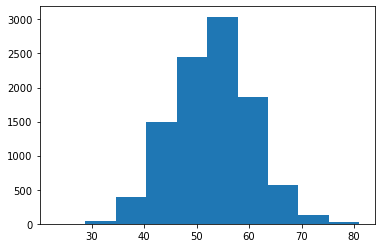

In [12]:
#distribution
plt.hist(audit);

In [13]:
#mean
np.array(audit).mean().round(2)

52.78

In [14]:
#expected arrivals from data.
round(sum(arrivals['arrival_rate'] * 60), 2)

53.07